# Various examples with the Spectrum object

In [45]:
# Reload
%load_ext autoreload
%autoreload 2

from becquerel import Spectrum
import numpy as np
np.random.seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Basic properties

Let's load a spectrum from a file and look at some of its basic properties.

In [46]:
spec = Spectrum.from_file('../tests/samples/1110C NAA cave pottery.Spe')

SpeFile: Reading file ../tests/samples/1110C NAA cave pottery.Spe


How many channels?

In [47]:
len(spec)

16384

Did an energy calibration get loaded from the file?

In [48]:
spec.is_calibrated

True

When was this spectrum acquired? How long is it?

In [49]:
print(spec.start_time)
print(spec.stop_time)
print(spec.realtime)
print(spec.livetime)

2017-04-25 12:54:27
2017-04-25 17:30:24
16557.0
16543.0


Let's take a look at the counts in some of the bins.

In [50]:
spec.counts_vals[7980:8010]

array([ 7.,  9.,  3.,  4.,  6.,  8.,  2.,  7.,  8., 12.,  6.,  9., 13.,
       28., 22., 19., 14., 20., 13.,  9., 15.,  6.,  5.,  5.,  3.,  1.,
        2.,  1.,  0.,  0.])

What energy are those bins at?

In [51]:
spec.energies_kev[7980:8010]

array([1458.69631121, 1458.87910415, 1459.06189709, 1459.24469003,
       1459.42748296, 1459.6102759 , 1459.79306883, 1459.97586177,
       1460.1586547 , 1460.34144763, 1460.52424056, 1460.70703348,
       1460.88982641, 1461.07261933, 1461.25541226, 1461.43820518,
       1461.6209981 , 1461.80379102, 1461.98658394, 1462.16937685,
       1462.35216977, 1462.53496268, 1462.71775559, 1462.9005485 ,
       1463.08334141, 1463.26613432, 1463.44892723, 1463.63172013,
       1463.81451304, 1463.99730594])

## Uncertainties, CPS, coarser binning

The counts include uncertainty by default.

In [52]:
print('counts: {}'.format(spec.counts[7990:7997]))
print('counts_vals: {}'.format(spec.counts_vals[7990:7997]))
print('counts_uncs: {}'.format(spec.counts_uncs[7990:7997]))

counts: [6.0+/-2.449489742783178 9.0+/-3.0 13.0+/-3.605551275463989
 28.0+/-5.291502622129181 22.0+/-4.69041575982343 19.0+/-4.358898943540674
 14.0+/-3.7416573867739413]
counts_vals: [ 6.  9. 13. 28. 22. 19. 14.]
counts_uncs: [2.44948974 3.         3.60555128 5.29150262 4.69041576 4.35889894
 3.74165739]


We also have access to CPS, and CPS/keV, with their values and uncertainties.

In [53]:
print('cps:      {}'.format(spec.cps[7990:7997]))
print('cps_vals: {}'.format(spec.cps_vals[7990:7997]))
print('cps_uncs: {}'.format(spec.cps_uncs[7990:7997]))
print()
print('cpskev:   {}'.format(spec.cpskev[7990:7997]))

cps:      [0.00036269116847004775+/-0.00014806804949423792
 0.0005440367527050716+/-0.00018134558423502388
 0.0007858308650184368+/-0.0002179502675127842
 0.0016925587861935563+/-0.0003198635448303924
 0.0013298676177235084+/-0.00028352872875678106
 0.0011485220334884845+/-0.0002634890251792706
 0.0008462793930967781+/-0.0002261776816039377]
cps_vals: [0.00036269 0.00054404 0.00078583 0.00169256 0.00132987 0.00114852
 0.00084628]
cps_uncs: [0.00014807 0.00018135 0.00021795 0.00031986 0.00028353 0.00026349
 0.00022618]

cpskev:   [0.001984164117225736+/-0.0008100316088571466
 0.002976246198195663+/-0.000992082066065221
 0.004299022318581503+/-0.0011923342618468994
 0.00925943275574236+/-0.001749868310944269
 0.0072752686484572095+/-0.0015510924875305908
 0.006283186607229465+/-0.001441461866543233
 0.004629716482204129+/-0.001237343776736296]


For some analyses, 16k bins might be too fine.

In [54]:
print('Current bin width: {}'.format(np.mean(spec.bin_widths)))

spec2 = spec.combine_bins(4)
print('New number of channels: {}'.format(len(spec2)))
print('New bin width: {}'.format(np.mean(spec2.bin_widths)))
print(spec2.counts_vals[1995:2005])

Current bin width: 0.18279265121922095
New number of channels: 4096
New bin width: 0.7311706048768838
[23. 23. 35. 82. 56. 31.  7.  1.  3.  2.]


Where exactly are these bins?

In [55]:
print(spec.bin_edges_kev[7980:8010])
print(spec2.bin_edges_kev[1995:2005])

[1458.60491474 1458.78770768 1458.97050062 1459.15329356 1459.3360865
 1459.51887943 1459.70167237 1459.8844653  1460.06725823 1460.25005116
 1460.43284409 1460.61563702 1460.79842995 1460.98122287 1461.1640158
 1461.34680872 1461.52960164 1461.71239456 1461.89518748 1462.0779804
 1462.26077331 1462.44356622 1462.62635914 1462.80915205 1462.99194496
 1463.17473787 1463.35753078 1463.54032368 1463.72311659 1463.90590949]
[1458.60491474 1459.3360865  1460.06725823 1460.79842995 1461.52960164
 1462.26077331 1462.99194496 1463.72311659 1464.45428819 1465.18545977]


## Spectrum arithmetic, downsampling

Let's introduce a second spectrum, a long background measurement.

In [56]:
bg = Spectrum.from_file('../tests/samples/1110C NAA cave background May 2017.spe')
print('Start time: {}'.format(bg.start_time))
print('Stop time:  {}'.format(bg.stop_time))

SpeFile: Reading file ../tests/samples/1110C NAA cave background May 2017.spe
Start time: 2017-04-26 11:05:11
Stop time:  2017-05-01 12:43:34


Since `spec` and `bg` have the same binning, we can add them together.

In [57]:
print('Pottery spectrum:    {:7.0f} counts in {:6.0f} s livetime'.format(
    np.sum(spec.counts_vals), spec.livetime))
print('Background spectrum: {:7.0f} counts in {:6.0f} s livetime'.format(
    np.sum(bg.counts_vals), bg.livetime))

spec_and_bg = spec + bg
print('Combined spectrum:   {:7.0f} counts in {:6.0f} s livetime'.format(
    np.sum(spec_and_bg.counts_vals), spec_and_bg.livetime))

Pottery spectrum:     304706 counts in  16543 s livetime
Background spectrum: 1052900 counts in 437817 s livetime


TypeError: Spectrum addition/subtraction must involve a Spectrum object

Subtraction works differently. Subtracting counts from counts is not meaningful, but subtracting countrates is essential for background subtraction. So the subtraction operation calculates with countrates only.

In [58]:
print('Total pottery countrate:    {:6.3f}'.format(np.sum(spec.cps)))
print('Total background countrate: {:6.3f}'.format(np.sum(bg.cps)))

bgsub = spec - bg
print('Total subtracted countrate: {:6.3f}'.format(np.sum(bgsub.cps)))
print('')
print('In the K-40 peak:')
print('Pottery counts: {}'.format(spec.counts_vals[7990:7997]))
print('Pottery cps: {}'.format(spec.cps_vals[7990:7997]))
print('Background counts: {}'.format(bg.counts_vals[7990:7997]))
print('Background cps: {}'.format(bg.cps_vals[7990:7997]))
print('Subtracted cps: {}'.format(bgsub.cps[7990:7997]))

Total pottery countrate:    18.419+/- 0.034
Total background countrate:  2.405+/- 0.002


TypeError: Spectrum addition/subtraction must involve a Spectrum object

Looks like there's no sign of K-40 in that pottery.

Counts and livetime are not meaningful in a subtracted spectrum.

We can also scale a spectrum up or down manually.

In [59]:
print(spec.counts_vals[7990:7997])
spec3 = spec * 25.7
print(spec3.counts_vals[7990:7997])
spec4 = spec / 2.3
print(spec4.counts_vals[7990:7997])

[ 6.  9. 13. 28. 22. 19. 14.]
[154.2 231.3 334.1 719.6 565.4 488.3 359.8]
[ 2.60869565  3.91304348  5.65217391 12.17391304  9.56521739  8.26086957
  6.08695652]


But if we want to simulate a shorter or weaker spectrum, downsampling will give us realistic statistics.

In [60]:
spec5 = spec.downsample(2.3)
print(spec5.counts_vals[7990:7997])

[ 2.  5.  6. 13. 14.  5.  6.]


## List mode data from an ADC

First, let's create some synthetic list-mode data of a Gaussian peak

In [136]:
import matplotlib.pyplot as plt

nsamples = 10000
lmd = np.random.normal(5000, 250, nsamples)

We can create a Spectrum object from the data using default settings

nbins = 6061
Uniform bins? True


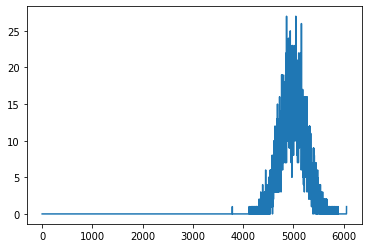

In [137]:
spec6 = Spectrum.from_listmode(lmd)
print('nbins =', spec6.get_nbins())
print('Uniform bins?', spec6.has_uniform_bins())
plt.plot(spec6.counts_vals)
plt.show()

Or specify bins and ranges ourselves

nbins = 1000
Uniform bins? True


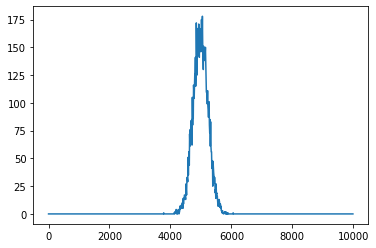

In [138]:
spec7 = Spectrum.from_listmode(lmd, bins=1000, xmin=0, xmax=10000)
print('nbins =', spec7.get_nbins())
print('Uniform bins?', spec7.has_uniform_bins())
plt.plot(spec7.bin_edges_kev[:-1], spec7.counts_vals)
plt.show()
# Note that the Spectrum.plot() method fails here because it works in bin mode.
# There might be a kwargs solution to that problem, but it should be fixed later.
# Note also that we still call bin_edges_kev, because bin_edges_adc has not yet been implemented.

We can even specify an array of (possibly non-uniform) bins

nbins = 119
Uniform bins? False
[15.43616208 15.49601408 15.55609815 15.61641519 15.6769661  15.73775179
 15.79877317 15.86003115 15.92152666 15.9832606  16.04523391 16.10744752
 16.16990235 16.23259935 16.29553945 16.35872358 16.42215271 16.48582778
 16.54974974 16.61391955 16.67833818 16.74300657 16.80792572 16.87309658
 16.93852013 17.00419735 17.07012924 17.13631676 17.20276092 17.26946271
 17.33642313 17.40364318 17.47112386 17.5388662  17.6068712  17.67513988
 17.74367327 17.81247238 17.88153826 17.95087194 18.02047444 18.09034682
 18.16049013 18.23090541 18.30159371 18.3725561  18.44379364 18.5153074
 18.58709844 18.65916784 18.73151669 18.80414606 18.87705704 18.95025072
 19.02372821 19.0974906  19.17153899 19.2458745  19.32049823 19.39541131
 19.47061486 19.54611    19.62189786 19.69797959 19.77435631 19.85102917
 19.92799933 20.00526792 20.08283612 20.16070508 20.23887597 20.31734996
 20.39612822 20.47521193 20.55460229 20.63430047 20.71430767 20.79462509
 20.87525393 20.9561

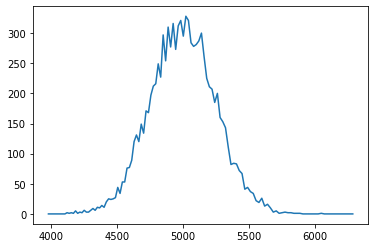

In [139]:
logbins = np.logspace(3.6, 3.8, num=120)
spec8 = Spectrum.from_listmode(lmd, bins=logbins)
print('nbins =', spec8.get_nbins())
print('Uniform bins?', spec8.has_uniform_bins())
print(spec8.bin_widths)
plt.plot(spec8.bin_edges_kev[:-1], spec8.counts_vals)
plt.show()

Find the bins corresponding to a particular channel

In [143]:
print(spec7.find_bin(3996))
print(spec7.find_bin(0))
print(spec7.find_bin(9999))

399
0
999


In [144]:
# test that the bin up edge is out-of-range
try:
    print(spec7.find_bin(10000))
except AssertionError:
    print("Failed successfully!")

Failed successfully!


In [145]:
print(spec8.find_bin(3996))
print(spec8.bin_edges_kev[0])
print(spec8.bin_edges_kev[1])

0
3981.0717055349733
3996.5078676179


Read in from a list-mode h5

In [148]:
import tables
lmd = tables.open_file('../tests/samples/cllbc_listmode.h5', 'r').root.Energy
spec9 = Spectrum.from_listmode(lmd, bins=500, xmin=0, xmax=1000000)

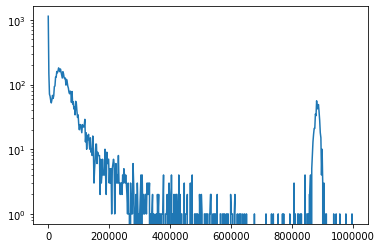

In [149]:
plt.figure()
plt.plot(spec9.bin_edges_kev[:-1], spec9.counts_vals)
plt.yscale('log')
plt.show()